# Computer Vision Demo
## Practical Implementation of Image Classification with PyTorch using Fashion MNIST Dataset

**Run the Computer Vision Demo in a colab notebook**

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/murilogustineli/computer-vision-demo/blob/main/cv_demo.ipynb)

**References:**
- [TensorFlow tutorial: Basic Image Classification](https://www.tensorflow.org/tutorials/keras/classification?linkId=9317518)
- [Fashion MNIST GitHub repo](https://github.com/zalandoresearch/fashion-mnist)
- [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)

Welcome to this practical implementation, where we delve into the world of computer vision using PyTorch. Our goal is to develop a practical understanding of Convolutional Neural Networks (CNNs) by implementing a model that can classify different types of clothing. This demo is designed for learners at all levels, so don't worry if some concepts seem new. We'll walk through each step of the process, explaining the key ideas and code details along the way.

In [1]:
# PyTorch
import torch

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.1.2


## 1. The Fashion MNIST dataset

In this demo, we use the `Fashion MNIST` dataset, a modern alternative to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset traditionally used for handwriting recognition. 

Fashion MNIST comprises 70,000 grayscale images, each 28x28 pixels, distributed across 10 different clothing categories. These images are small, detailed, and varied enough to challenge our model while being simple enough for straightforward processing and quick training times.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

### 1.1 Dataset Structure

The dataset is split into two parts:

- **Training Set:** This includes `train_images` and `train_labels`. These are the arrays that our model will learn from. The model sees these images and their corresponding labels, adjusting its weights and biases to reduce classification error.

- **Test Set:** This comprises `test_images` and `test_labels`. These are used to evaluate how well our model performs on data it has never seen before. This is crucial for understanding the model's generalization capability.

### 1.2 Understanding the Data

Each image in the dataset is a 28x28 NumPy array. The pixel values range from 0 to 255, with 0 being black, 255 being white, and the various shades of gray in between. The labels are integers from 0 to 9, each representing a specific category of clothing.
Class Names

The dataset doesn't include the names of the clothing classes, so we will manually define them for clarity when visualizing our results. Here's the mapping:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>


In the following sections, we will load and preprocess this data, design and train a CNN, and finally evaluate its performance on the test set. Let's get started!


In [2]:
# Defining class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot',
]

## 2. Loading the dataset

Let's load the Fashion MNIST dataset directly from PyTorch:

In [78]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    data_dir = '/content/FashionMNIST_data/'
else:
    data_dir = './FashionMNIST_data/'  # Relative path for local execution

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Seed for reproducibility
torch.manual_seed(7) # 7, 100

# Download and load the training data
trainset = datasets.FashionMNIST(data_dir, download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(data_dir, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

**Defining Transformations:**
- `transforms.ToTensor()`: Converts the images into PyTorch tensors and scales the pixel values to the range [0, 1].
- `transforms.Normalize((0.5,), (0.5,))`: Normalizes the tensor images so that each pixel value is centered around 0 and falls within the range [-1, 1]. This normalization helps in stabilizing the learning process and often leads to faster convergence in deep learning models.

### 2.1 Using DataLoader

The `DataLoader` in PyTorch provides batches of data, and you can iterate through these batches to collect all images and labels. This method is memory-efficient and is typically used when dealing with large datasets.

In [79]:
def extract_images_labels(loader):
    images = []
    labels = []
    for batch in loader:
        b_images, b_labels = batch
        images.append(b_images)
        labels.append(b_labels)
    return torch.cat(images, dim=0), torch.cat(labels, dim=0)

# Extracting train and test images and labels
train_images, train_labels = extract_images_labels(trainloader)
test_images, test_labels = extract_images_labels(testloader)

**Important Notes:**
- This method will load the entire dataset into memeory, which is fine for small datasets like the Fashion MNIST, but might not be feasible for significantly larger datasets.
- `train_images` and `test_images` will be tensors containing the image data, and `train_labels` and `test_labels` will be tensors containing the corresponding labels.
- These tensors can then be used directly for training and evaluation in your models.

## 3. Exploring the data

Before training our model, it's essential to understand the Fashion MNIST dataset's format and structure. This understanding helps in effectively tailoring our model and preprocessing steps.

### 3.1 Understanding the Training Set

- **Size and Shape of Training Images:** The shape of the train_images tensor provides insight into the number of images and their dimensions.
    
    The shape is represented as (N, C, H, W), where:
    - N = Number of images
    - C = Number of color channels per image (For grayscale images, C = 1)
    - H = Height of each image in pixels
    - W = Width of each image in pixels

In our dataset, each image is a 28 x 28 pixel grayscale image, so the shape will be (60000, 1, 28, 28), indicating 60,000 images with 1 color channel and 28x28 pixel resolution.

In [65]:
train_images.shape  # Output expected: (60000, 1, 28, 28)

torch.Size([60000, 1, 28, 28])

- **Training Labels:** The total number of labels in the training set should match the number of images. Each label corresponds to a category of fashion item.

In [66]:
len(train_labels)   # Output expected: 60000

60000

- **Label Range:** Each label is an integer from 0 to 9, where each number corresponds to a specific category (like T-shirts, trousers, etc.).

In [67]:
train_labels        # Output example: tensor([9, 8, 3, ..., 7, 7, 6])

tensor([1, 4, 5,  ..., 6, 4, 8])

### 3.2 Understanding the Test Set

- **Size and Shape of Test Images:** The test set should have a similar structure but with fewer images, typically used for evaluating the model's performance.


In [68]:
test_images.shape   # Output expected: (10000, 1, 28, 28)

torch.Size([10000, 1, 28, 28])

- **Test Labels:** The test set contains labels corresponding to each image, used to verify the model's predictions.

In [69]:
len(test_labels)    # Output expected: 10000

10000

## 4. Data Preprocessing

Before training our neural network, it's crucial to preprocess the data. This involves scaling the pixel values of the images to a standard range, which helps the network learn more efficiently.

### 4.1 Understanding Pixel Values:
- Each image in the Fashion MNIST dataset is represented in grayscale with pixel values ranging from 0 to 255. The value 0 represents black, 255 represents white, and the values in between represent various shades of gray.
- Inspecting the first image in the training set highlights these pixel values:

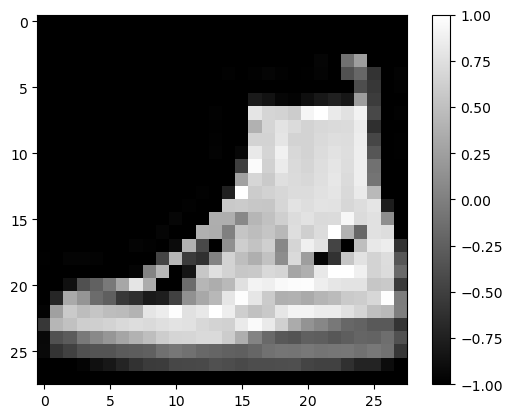

In [80]:
# Plotting firt image
plt.figure()
plt.imshow(train_images[0][0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### 4.2 Verifying the Data Format:

- Before building the model, it's a good practice to visualize the data to ensure it's in the correct format. Displaying the first 25 images from the training set can help us confirm that the data is ready for model training.
- Additionally, displaying the class name below each image ensures that the labels correspond correctly to the images:

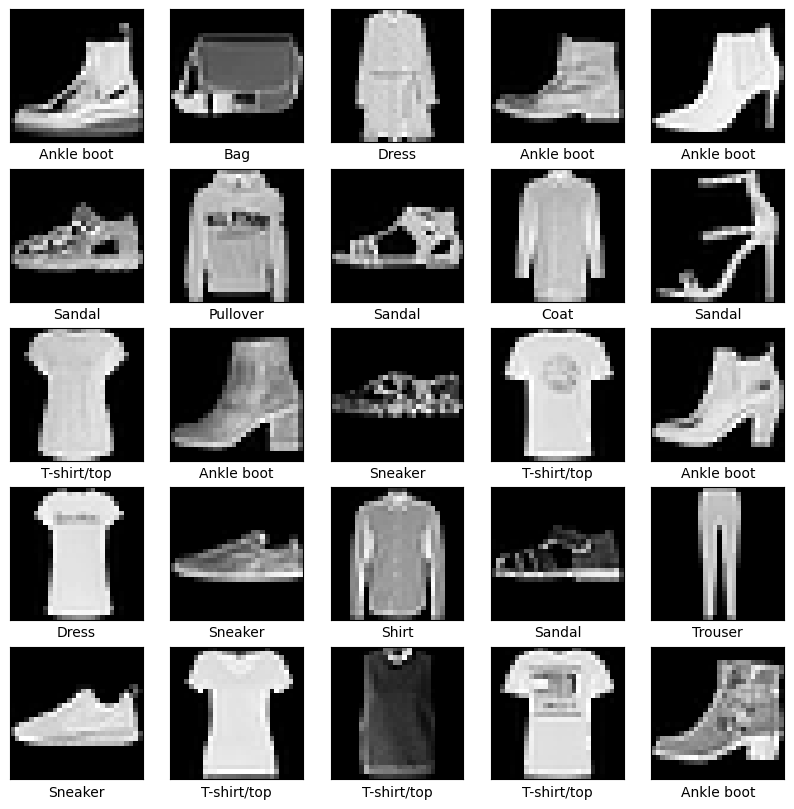

In [81]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][0], cmap='gray') 
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Model Training